# Hypothesis Testing for Companies
Businesses conduct hypothesis testing to look into different company data to find new incites and ways to improve their business. In this project we will run different hypothesis tests to see which new questions hold statistical significance. Companies can use what we find to improve their sales and business over all.
The five questions posed are:
        1. Do discounts have an impact on the quantity of items on orders?
        2. Does the level of discount affect the quantity of items ordered?
        3. Does the unit price of an object affect the level of discount?
        4. Is the level of discount equal for the different categories?
        5. Does the quantity of items ordered similar for each category?


In [95]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
%matplotlib inline

In [96]:
con = sqlite3.connect('Northwind_small.sqlite')
c = con.cursor()
print("Opened database successfully")

Opened database successfully


In [97]:
for row in c.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    print(row)

('Employee',)
('Category',)
('Customer',)
('Shipper',)
('Supplier',)
('Order',)
('Product',)
('OrderDetail',)
('CustomerCustomerDemo',)
('CustomerDemographic',)
('Region',)
('Territory',)
('EmployeeTerritory',)
('SCHOOL',)


In [98]:
employee_table = pd.read_sql_query("SELECT * FROM Employee", con)
category_table = pd.read_sql_query("SELECT * FROM Category", con)
customer_table = pd.read_sql_query("SELECT * FROM Customer", con)
shipper_table = pd.read_sql_query("SELECT * FROM Shipper", con)
supplier_table = pd.read_sql_query("SELECT * FROM Supplier", con)
order_table = pd.read_sql_query("SELECT * FROM [Order]", con)
product_table = pd.read_sql_query("SELECT * FROM Product", con)
orderdetail_table = pd.read_sql_query("SELECT * FROM OrderDetail", con)
customercustomerdemo_table = pd.read_sql_query("SELECT * FROM CustomerCustomerDemo", con)
customerdemographic_table = pd.read_sql_query("SELECT * FROM CustomerDemographic", con)
region_table = pd.read_sql_query("SELECT * FROM Region", con)
territory_table = pd.read_sql_query("SELECT * FROM Territory", con)
employeeterritory_table = pd.read_sql_query("SELECT * FROM EmployeeTerritory", con)


 # Question 1: Are the mean quantities of nondiscounted orders equal to the mean quantity of discounted orders?

## Data exploration 

In [99]:
orderdetail_table.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [100]:
#breakdown the table into data sets by discount in groups of 5%. Also divided data into all discounted and nondiscounted
discount_0_05 = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount BETWEEN 0.001 and .05", con)
print("Total number of orders discounted from 1% to 5%= {}".format(len(discount_0_05)))
discount_05_1 = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount BETWEEN .051 and .1", con)
print("Total number of orders discounted from 5% to 10%= {}".format(len(discount_05_1)))
discount_1_15 = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount BETWEEN .11 and .15", con)
print("Total number of orders discounted from 10% to 15%= {}".format(len(discount_1_15)))
discount_15_2 = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount BETWEEN .151 and .20", con)
print("Total number of orders discounted from 15% to 20%= {}".format(len(discount_15_2)))
discount_2_25 = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount BETWEEN .21 and .25", con)
print("Total number of orders discounted from 20% to 25%= {}".format(len(discount_2_25)))

no_discount = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount = 0", con)
print("Total number of orders with no discount= {}".format(len(no_discount)))
discounts = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount BETWEEN .001 and .25", con)
print("Total number of orders discounted = {}".format(len(discounts)))


Total number of orders discounted from 1% to 5%= 192
Total number of orders discounted from 5% to 10%= 174
Total number of orders discounted from 10% to 15%= 157
Total number of orders discounted from 15% to 20%= 161
Total number of orders discounted from 20% to 25%= 154
Total number of orders with no discount= 1317
Total number of orders discounted = 838


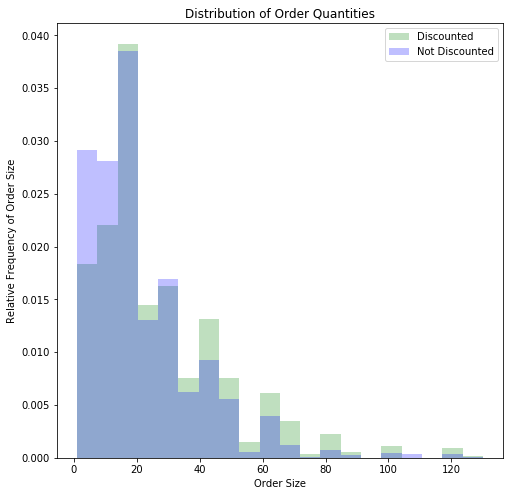

In [101]:
#plot discount and no discount
plt.figure(figsize=(8,8))
plt.hist(discounts['Quantity'], bins=20, alpha=.25, density=True, color ='g', label="Discounted")
plt.hist(no_discount['Quantity'], bins=20, alpha=.25, density=True, color='b', label="Not Discounted")
plt.title("Distribution of Order Quantities")
plt.ylabel("Relative Frequency of Order Size")
plt.xlabel("Order Size")
plt.legend()
plt.show()

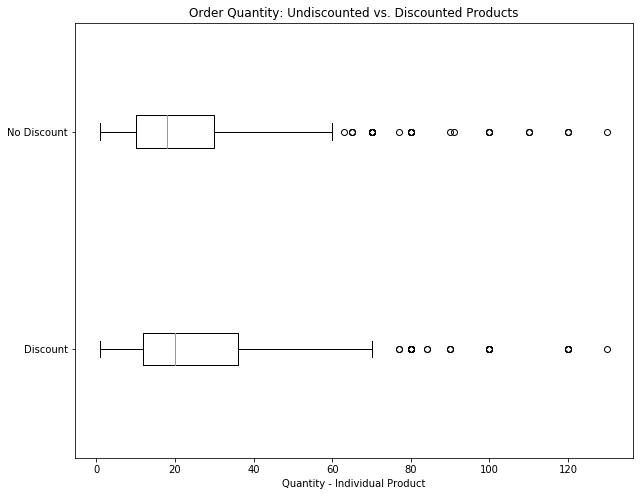

In [102]:
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot([discounts['Quantity'], no_discount['Quantity']], vert=False, labels=("Discount", "No Discount"))
ax.set_title("Order Quantity: Undiscounted vs. Discounted Products")
ax.set_xlabel("Quantity - Individual Product")
plt.grid(False)
plt.show()

### $H0: \mu_0 = \mu_1$
### $HA: \mu_0 \neq \mu_1$

In [103]:
#using the levene test to test if there is a significance 
#p is less then .05 so we reject the null hypothesis and cant use ANOVA
print(stats.levene(no_discount['Quantity'], discount_0_05['Quantity']))
print(stats.levene(no_discount['Quantity'], discount_05_1['Quantity']))
print(stats.levene(no_discount['Quantity'], discount_1_15['Quantity']))
print(stats.levene(no_discount['Quantity'], discount_15_2['Quantity']))
print(stats.levene(no_discount['Quantity'], discount_2_25['Quantity']))

print(stats.levene(no_discount['Quantity'], discounts['Quantity']))

LeveneResult(statistic=7.598798646837281, pvalue=0.005911146478108135)
LeveneResult(statistic=1.9602714878584622, pvalue=0.1616926093213866)
LeveneResult(statistic=6.621394134971047, pvalue=0.010173258822969699)
LeveneResult(statistic=4.2893069280815554, pvalue=0.038526244167615964)
LeveneResult(statistic=4.191961687777951, pvalue=0.04079361481086336)
LeveneResult(statistic=14.832671704073421, pvalue=0.00012091378376079568)


Above we tested the variance and got all but one pvalue to be less than .05, which means the variance is not equal throughout. Since the variance is not equal we will use a Welch Test to find statistical significance. 

In [104]:
# Levene test has a p value less than .05, meaning the variance is not equal. We must do the welch test
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.16f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")

welch_ttest(no_discount['Quantity'], discounts['Quantity'])




 Welch's t-test= -6.2391 
 p-value = 0.0000000005656414 
 Welch-Satterthwaite Degrees of Freedom= 1561.7678


## Conclusion 

P value is less than .05, **which means we reject the null hypothesis**. This means that the mean quantity of non discounted orders does not equal the mean quantity of disocunted orders. This makes sense because we would assume that an item having a discount would effect the quantity of items a customer purchases.

# Question 2: Does the level of discount affect the quantity of items ordered?

### $H0: \mu_0 = \mu_1$
### $HA: \mu_0 \neq \mu_1$

In [105]:
#mean quantity of orders for the different levels of discount 
print(np.mean(no_discount['Quantity']))
print(np.mean(discount_0_05['Quantity']))
print(np.mean(discount_05_1['Quantity']))
print(np.mean(discount_1_15['Quantity']))
print(np.mean(discount_15_2['Quantity']))
print(np.mean(discount_2_25['Quantity']))

21.715261958997722
27.052083333333332
25.103448275862068
28.38216560509554
27.024844720496894
28.24025974025974


We will run an ANOVA test to compare all the discounted values at once to see if one discount value is more significant than the other. To run the ANOVA test, we are using a random sample of 100 from each discount group. We did this because the non discounted group is so much larger we did not want it to scew the results.

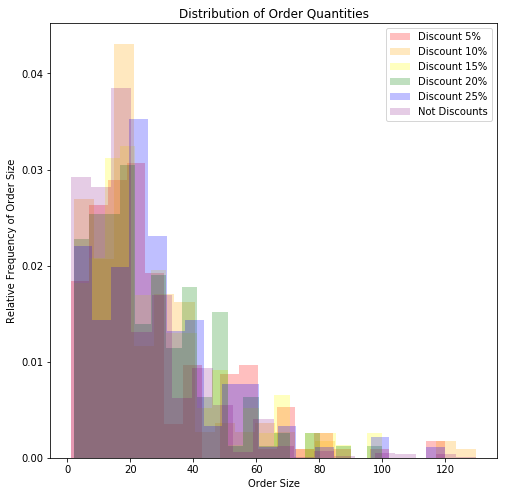

In [106]:
plt.figure(figsize=(8,8))
plt.hist(discount_0_05['Quantity'], bins=20, alpha=.25, density=True, color ='red', label="Discount 5%")
plt.hist(discount_05_1['Quantity'], bins=20, alpha=.25, density=True, color ='orange', label="Discount 10%")
plt.hist(discount_1_15['Quantity'], bins=20, alpha=.25, density=True, color ='yellow', label="Discount 15%")
plt.hist(discount_15_2['Quantity'], bins=20, alpha=.25, density=True, color ='green', label="Discount 20%")
plt.hist(discount_2_25['Quantity'], bins=20, alpha=.25, density=True, color ='blue', label="Discount 25%")
plt.hist(no_discount['Quantity'], bins=20, alpha=.2, density=True, color='purple', label="Not Discounts")
plt.title("Distribution of Order Quantities")
plt.ylabel("Relative Frequency of Order Size")
plt.xlabel("Order Size")
plt.legend()
plt.show()

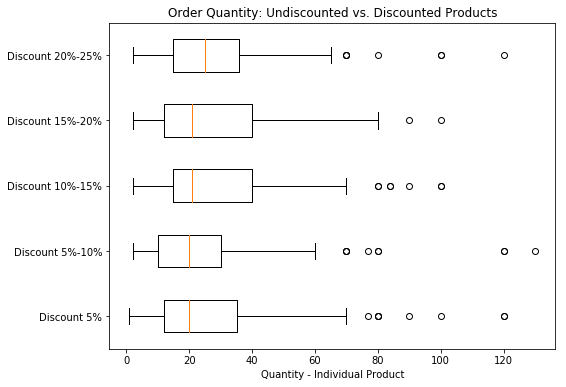

In [107]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot([discount_0_05['Quantity'], discount_05_1['Quantity'], discount_1_15['Quantity'], 
            discount_15_2['Quantity'], discount_2_25['Quantity']], vert=False, labels=("Discount 5%", 
            "Discount 5%-10%", "Discount 10%-15%", "Discount 15%-20%", "Discount 20%-25%"))
ax.set_title("Order Quantity: Undiscounted vs. Discounted Products")
ax.set_xlabel("Quantity - Individual Product")
plt.grid(False)
plt.show()

In [111]:
#make random data set of 100 values for each discount to make sure the number of values is equal
d0 = np.random.choice(no_discount['Quantity'], size=100)
d05 = np.random.choice(discount_0_05['Quantity'], size=100)
d1 = np.random.choice(discount_05_1['Quantity'],size=100)
d15 = np.random.choice(discount_1_15['Quantity'],size=100)
d2 = np.random.choice(discount_15_2['Quantity'],size=100)
d25 = np.random.choice(discount_2_25['Quantity'],size=100)

# DO A TUKEY TEST

In [112]:
D = [d05, d1, d15, d2, d25]
l = ['5% discount', '5%-10%', '10%-15%', '15%-20%', '20%-25%']
tukey_results = pairwise_tukeyhsd(D, l, 0.05)
print(tukey_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff   lower    upper   reject
--------------------------------------------------
10%-15% 15%-20%  9.3333  -126.8075 145.4742 False 
10%-15% 20%-25% -26.6667 -162.8075 109.4742 False 
15%-20% 20%-25%  -36.0   -202.7378 130.7378 False 
--------------------------------------------------


## Conclusion

The P value is greater than .05 so **we accept the null hypothesis**. This means that the mean quantity of items ordered is the same throughout the different levels of discount. Meaning higher discounted items are not necessarily ordered more than items with a small discount. 

# Question 3: Does the unit price of an object affect the level of discount?

### $H0: \mu_0 = \mu_1$
### $HA: \mu_0 \neq \mu_1$

In [113]:
price_0_50 = pd.read_sql_query("SELECT * FROM orderdetail WHERE UnitPrice BETWEEN 0 and 50", con)
print("Total number of items order where Unit Price ranges from 0 to 50= {}".format(len(price_0_50)))
price_50_100 = pd.read_sql_query("SELECT * FROM orderdetail WHERE UnitPrice BETWEEN 50.01 and 100", con)
print("Total number of items order where Unit Price ranges from 50 to 100= {}".format(len(price_50_100)))
price_100_150 = pd.read_sql_query("SELECT * FROM orderdetail WHERE UnitPrice BETWEEN 100.01 and 150", con)
print("Total number of items order where Unit Price ranges from 100 to 150= {}".format(len(price_100_150)))
price_150_200 = pd.read_sql_query("SELECT * FROM orderdetail WHERE UnitPrice BETWEEN 150.01 and 200", con)
print("Total number of items order where Unit Price ranges from 150 to 200= {}".format(len(price_150_200)))
price_200_250 = pd.read_sql_query("SELECT * FROM orderdetail WHERE UnitPrice BETWEEN 200.01 and 250", con)
print("Total number of items order where Unit Price ranges from 200 to 250= {}".format(len(price_200_250)))
price_250_300 = pd.read_sql_query("SELECT * FROM orderdetail WHERE UnitPrice BETWEEN 250.01 and 300", con)
print("Total number of items order where Unit Price ranges from 250 to 300= {}".format(len(price_250_300)))

Total number of items order where Unit Price ranges from 0 to 50= 1992
Total number of items order where Unit Price ranges from 50 to 100= 117
Total number of items order where Unit Price ranges from 100 to 150= 22
Total number of items order where Unit Price ranges from 150 to 200= 0
Total number of items order where Unit Price ranges from 200 to 250= 8
Total number of items order where Unit Price ranges from 250 to 300= 16


/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:815: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


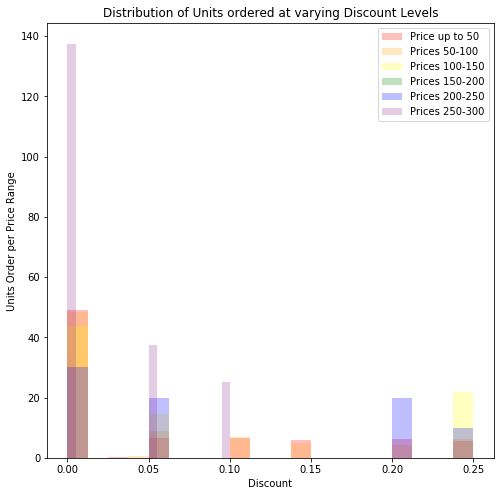

In [114]:
plt.figure(figsize=(8,8))
plt.hist(price_0_50['Discount'], bins=20, alpha=.25, density=True, color ='red', label="Price up to 50")
plt.hist(price_50_100['Discount'], bins=20, alpha=.25, density=True, color ='orange', label="Prices 50-100")
plt.hist(price_100_150['Discount'], bins=20, alpha=.25, density=True, color ='yellow', label="Prices 100-150")
plt.hist(price_150_200['Discount'], bins=20, alpha=.25, density=True, color ='green', label="Prices 150-200")
plt.hist(price_200_250['Discount'], bins=20, alpha=.25, density=True, color ='blue', label="Prices 200-250")
plt.hist(price_250_300['Discount'], bins=20, alpha=.2, density=True, color='purple', label="Prices 250-300")
plt.title("Distribution of Units ordered at varying Discount Levels")
plt.ylabel("Units Order per Price Range")
plt.xlabel("Discount")
plt.legend()
plt.show()

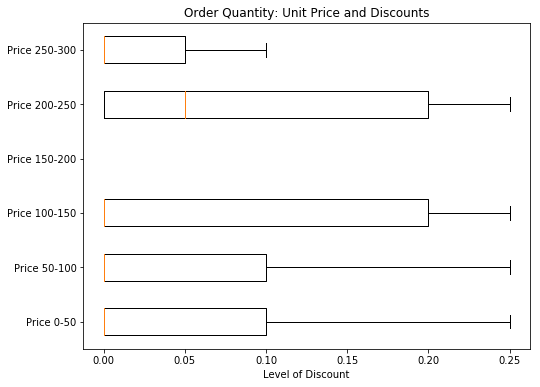

In [115]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot([price_0_50['Discount'], price_50_100['Discount'], price_100_150['Discount'], price_150_200['Discount'],
            price_200_250['Discount'], price_250_300['Discount']], vert=False, labels=("Price 0-50", 
            "Price 50-100", "Price 100-150", "Price 150-200", "Price 200-250", "Price 250-300"))
ax.set_title("Order Quantity: Unit Price and Discounts")
ax.set_xlabel("Level of Discount")
plt.grid(False)
plt.show()

In [116]:
#check variance
print(stats.levene(price_0_50['Discount'], price_50_100['Discount'], price_100_150['Discount'], 
                    price_200_250['Discount'], price_250_300['Discount']))

LeveneResult(statistic=1.2572042994778685, pvalue=0.2847133860905552)


Used the Levene Test to check variance. The p value is greater than .05 so we can use the ANOVA test to check statistical significance.

In [117]:
fstat, pval = stats.f_oneway(price_0_50['Discount'], price_50_100['Discount'], price_100_150['Discount'], 
                                price_200_250['Discount'], price_250_300['Discount'])

pval

0.2058050087140513

## Conclusion

The p value is greater than .05 so **we accept the null hypothesis**, this shows that the level of discount does not change depending on unit price of an item. Maybe if the discount was greater for more expensive items there would be an increase in orders. 

# Question 4: Is the level of discount equal for the different categories?

### $H0: \mu_0 = \mu_1$
### $HA: \mu_0 \neq \mu_1$

To run this test we firts need to join the order details and product tables to compare category ID and discount.

In [118]:
product_table.head(1)

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0


In [119]:
orderdetail_table.head(1)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0


In [120]:
join_query = """SELECT OrderDetail.ProductId, CategoryId, Quantity, Discount
FROM orderdetail
JOIN product 
ON orderdetail.ProductId = Product.Id"""

In [121]:
join_query

'SELECT OrderDetail.ProductId, CategoryId, Quantity, Discount\nFROM orderdetail\nJOIN product \nON orderdetail.ProductId = Product.Id'

In [122]:
odpdf = pd.read_sql_query(join_query, con)
odpdf.head()

,ProductId,CategoryId,Quantity,Discount
0,11,4,12,0.0
1,42,5,10,0.0
2,72,4,5,0.0
3,14,7,9,0.0
4,51,7,40,0.0


In [123]:
cat_1 = odpdf.loc[odpdf.CategoryId == 1]
cat_2 = odpdf.loc[odpdf.CategoryId == 2]
cat_3 = odpdf.loc[odpdf.CategoryId == 3]
cat_4 = odpdf.loc[odpdf.CategoryId == 4]
cat_5 = odpdf.loc[odpdf.CategoryId == 5]
cat_6 = odpdf.loc[odpdf.CategoryId == 6]
cat_7 = odpdf.loc[odpdf.CategoryId == 7]
cat_8 = odpdf.loc[odpdf.CategoryId == 8]

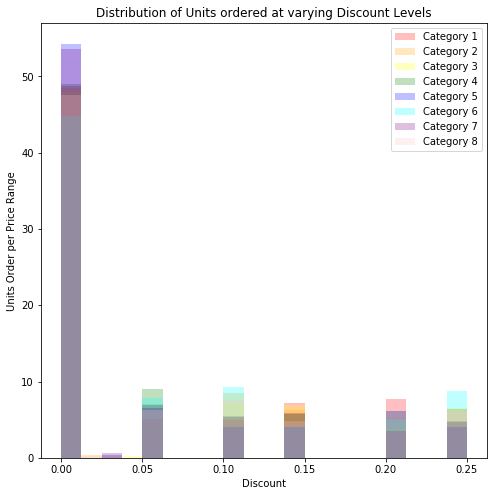

In [124]:
plt.figure(figsize=(8,8))
plt.hist(cat_1['Discount'], bins=20, alpha=.25, density=True, color ='red', label="Category 1")
plt.hist(cat_2['Discount'], bins=20, alpha=.25, density=True, color ='orange', label="Category 2")
plt.hist(cat_3['Discount'], bins=20, alpha=.25, density=True, color ='yellow', label="Category 3")
plt.hist(cat_4['Discount'], bins=20, alpha=.25, density=True, color ='green', label="Category 4")
plt.hist(cat_5['Discount'], bins=20, alpha=.25, density=True, color ='blue', label="Category 5")
plt.hist(cat_6['Discount'], bins=20, alpha=.25, density=True, color ='cyan', label="Category 6")
plt.hist(cat_7['Discount'], bins=20, alpha=.25, density=True, color ='purple', label="Category 7")
plt.hist(cat_8['Discount'], bins=20, alpha=.25, density=True, color ='pink', label="Category 8")
plt.title("Distribution of Units ordered at varying Discount Levels")
plt.ylabel("Units Order per Price Range")
plt.xlabel("Discount")
plt.legend()
plt.show()

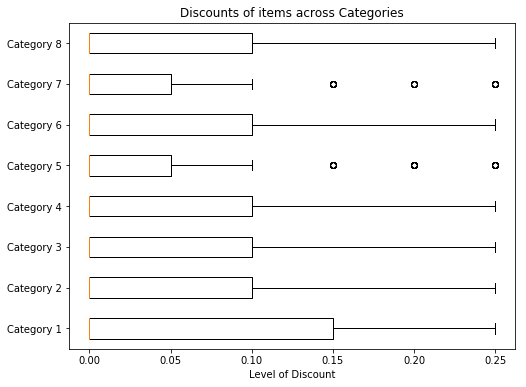

In [125]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot([cat_1['Discount'], cat_2['Discount'], cat_3['Discount'], cat_4['Discount'],
            cat_5['Discount'], cat_6['Discount'], cat_7['Discount'], cat_8['Discount']], 
           vert=False, labels=("Category 1", "Category 2", "Category 3", "Category 4", 
                               "Category 5", "Category 6", "Category 7", "Category 8"))
ax.set_title("Discounts of items across Categories")
ax.set_xlabel("Level of Discount")
plt.grid(False)
plt.show()

In [126]:
#levene test for variance
print(stats.levene(cat_1['Discount'], odpdf['Discount']))
print(stats.levene(cat_2['Discount'], odpdf['Discount']))
print(stats.levene(cat_3['Discount'], odpdf['Discount']))
print(stats.levene(cat_4['Discount'], odpdf['Discount']))
print(stats.levene(cat_5['Discount'], odpdf['Discount']))
print(stats.levene(cat_6['Discount'], odpdf['Discount']))
print(stats.levene(cat_7['Discount'], odpdf['Discount']))
print(stats.levene(cat_8['Discount'], odpdf['Discount']))

LeveneResult(statistic=1.5660052505513309, pvalue=0.21090257118992378)
LeveneResult(statistic=0.3549647724802563, pvalue=0.5513729733391813)
LeveneResult(statistic=0.025213163313157674, pvalue=0.8738499511136031)
LeveneResult(statistic=0.3364112030845873, pvalue=0.5619599787663906)
LeveneResult(statistic=3.074559184428751, pvalue=0.07965656988510599)
LeveneResult(statistic=1.5629717036461663, pvalue=0.21135639631791997)
LeveneResult(statistic=2.131745439316921, pvalue=0.14441361428607608)
LeveneResult(statistic=0.6770651777384927, pvalue=0.4106781698678509)


The p value is greater than .05 so we can assume equal variance. We will proceed by using the ANOVA test to test stitical significance. 

In [127]:
fstat, pval = stats.f_oneway(cat_1['Discount'], cat_2['Discount'], cat_3['Discount'], 
                                cat_4['Discount'], cat_5['Discount'], cat_6['Discount'],
                            cat_7['Discount'], cat_8['Discount'])

pval



0.14932558623997566

## Conclusion

The pvalue is greater than .05 so we **accept the null hypothesis**. This means we can assume the mean discount for each category is similar, meaning the category of items does not influence discounts. We can use this information to see if changing the discounts for certain categories can increase quantity in orders. 

# Question 5: Does the quantity of items ordered similar for each category?

### $H0: \mu_0 = \mu_1$
### $HA: \mu_0 \neq \mu_1$

In [128]:
#test variance
print(stats.levene(cat_1['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_2['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_3['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_4['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_5['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_6['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_7['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_8['Quantity'], odpdf['Quantity']))

LeveneResult(statistic=0.009848071775278997, pvalue=0.9209575185817495)
LeveneResult(statistic=0.04241228423250917, pvalue=0.836853577549603)
LeveneResult(statistic=0.15747281627033324, pvalue=0.6915280203518689)
LeveneResult(statistic=0.4978733557188787, pvalue=0.480501288733321)
LeveneResult(statistic=0.5788360158489891, pvalue=0.44684529034520126)
LeveneResult(statistic=1.3071043218749905, pvalue=0.25303725817201894)
LeveneResult(statistic=0.38228878918434794, pvalue=0.536442368692101)
LeveneResult(statistic=0.08724598699158045, pvalue=0.7677326472768746)


The p value is greater than .05 so we can assume equal variance. We will proceed by using the ANOVA test to test stitical significance. 

In [129]:
fstat, pval = stats.f_oneway(cat_1['Quantity'], cat_2['Quantity'], cat_3['Quantity'], 
                                cat_4['Quantity'], cat_5['Quantity'], cat_6['Quantity'],
                            cat_7['Quantity'], cat_8['Quantity'])

pval


0.8280581155634347

## Conclusion

The pvalue is greater than .05 so **we accept the null hypothesis** meaning we can assume the mean quantity ordered for each category is similar, meaning the category of items does not influence the amount ordered. We can use this information to see if there is a reason customers aren't ordering more of a certain category vs others, i.e. nonperishable items vs produce, dairy products, etc.